In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from math import factorial
#%matplotlib qt
%matplotlib inline
name, mass, r, x_pos, y_pos, z_pos = np.loadtxt("Chinchilla_L125_e1.txt",usecols=(0,1,2,6,7,8)).T
simulation_L = 125

In [2]:
def get_values(index, minmass=0, new_file = None):
    """
    Method to get values from a halo index, and optionally a new file.
    
    Parameters:
        index: int halo index from simulation 
        new_file: string file name 
    """
    
    # allow get_values to access a new file
    if new_file:
        new_name, new_mass, new_r, new_x_pos, new_y_pos, new_z_pos = np.loadtxt(new_file,usecols=(0,1,2,6,7,8)).T
        mask = np.logical_and((new_name==index), (new_mass>minmass))
        mvir, rvir, x, y, z = new_mass[mask], new_r[mask], new_x_pos[mask], new_y_pos[mask], new_z_pos[mask]
    else:
        mask = np.logical_and((name==index), (mass>minmass))
        mvir, rvir, x, y, z = mass[mask], r[mask], x_pos[mask], y_pos[mask], z_pos[mask]
    
    # mask values, incorporates periodic boundary conditions
    mask_x = (x-x[0]>2*rvir[0])
    #print(mask_x)
    x[mask_x]=x[mask_x]-simulation_L
    
    mask_x_case2 = (x[0]-x>2*rvir[0])
    x[mask_x_case2] = simulation_L+x[mask_x_case2]
    
    mask_z = (z-z[0]>2*rvir[0])
    z[mask_z]=z[mask_z]-simulation_L
    
    mask_z_case2 = (z[0]-z>2*rvir[0])
    z[mask_z_case2] = simulation_L+z[mask_z_case2]
    
    mask_y = (y-y[0]>2*rvir[0])
    y[mask_y]=y[mask_y]-simulation_L
    
    mask_y_case2 = (y[0]-y>2*rvir[0])
    y[mask_y_case2] = simulation_L+y[mask_y_case2]
    
    return mvir, rvir, x, y, z

In [3]:
def get_axes(data, nonzerocenter = True):
    """
    Method to get axis ratios from subhalos.
    
    Parameters:
        data: Nx3 array of subhalo coordinates, x y z
        nonzerocenter: Boolean; True meaning the halos are centered around the first halo
    """
    
    # define coordinates relative to center halo
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]
    #print(x)
    
    x = x[1:]-x[0]
    y = y[1:]-y[0]
    z = z[1:]-z[0]

    
    # setup
    M = np.zeros((3,3))
    # print(M)
    
    # calculate elements of tensor
    M[0][0] = np.sum(y**2 + z**2)
    M[1][1] = np.sum(z**2 + x**2)
    M[2][2] = np.sum(x**2 + y**2)
    M[0][1] = M[1][0] = -np.sum(x*y)
    M[0][2] = M[2][0] = -np.sum(x*z)
    M[1][2] = M[2][1] = -np.sum(y*z)
    
    # get eigenvalues + moments of inertia
    eigenvalues, eigenvectors = np.linalg.eig(M)
    I_a = eigenvalues[0] * 5 / x.shape[0]
    I_b = eigenvalues[1] * 5 / x.shape[0]
    I_c = eigenvalues[2] * 5 / x.shape[0]
    
    # calculate axes
    axes = np.zeros(3)
    axes[1] = np.sqrt((I_a - I_b + I_c)/2)
    axes[2] = np.sqrt(I_a - (axes[1]**2))
    axes[0] = np.sqrt(I_c - (axes[1]**2))
    
    #if np.isnan(np.sum(axes)):
        #print(axes)
    
    ordered_axes = np.sort(axes)
    ordered_axes = ordered_axes[::-1]
    
    return ordered_axes

In [4]:
def get_ca(data):
    """
    Method to get axis ratio c/a.
    
    Parameters:
        data: Nx3 array of subhalos with positions x,y,z
    """
    a, b, c = get_axes(data)
    return c/a


def get_a(data):
    """
    Method to get axis a.
    
    Parameters:
        data: Nx3 array of subhalos with positions x,y,z
    """
    a, b, c = get_axes(data)
    return a

def get_mean_pos(data):
    """
    Method to get mean positions.
    
    Parameters:
        data: NxM array - N points, M dimensions
    """
    
    return np.mean(np.abs(data[1:]-data[0]), axis=0)

# mean function
def mean(data):
    return np.mean(data, axis=0)

In [30]:
def bootstrap(dataset):
    """
    Method to perform bootstrap sampling on a dataset.
    """
    indices = np.arange(len(dataset))
    random_index = np.random.choice(indices[1:], len(dataset), replace=True)
    random_index[0] = 0
    return dataset[random_index]

In [6]:
def get_statistics(dataset, repetitions, function):
    """
    Method to perform bootstrap sampling repeatedly and calculate some value.
    
    Parameters:
        dataset: any array
        repetitions: number of times to repeat sampling 
        function: any function returning a numeric value
    """
    
    all_axes = []
    
    # for each sample, calculate axes
    for i in range(repetitions):
        sample = bootstrap(dataset)
        output = function(sample)
        all_axes.append(output)
    
    # return all axes
    return np.array(all_axes)

In [24]:
# idk
from astropy.stats import bootstrap as bootstrap_astropy
def get_statistics_test(dataset, repetitions, function):
    """
    Method to perform bootstrap sampling repeatedly and calculate some value.
    
    Parameters:
        dataset: any array
        repetitions: number of times to repeat sampling 
        function: any function returning a numeric value
    """
    
    all_axes = []
    
    # for each sample, calculate axes
    for i in range(repetitions):
        sample = bootstrap_astropy(dataset)
        output = function(sample)
        all_axes.append(output)
    
    # return all axes
    return np.array(all_axes)

In [7]:
def get_quantiles(data):
    """
    Method to get 1sigma, 2sigma, 3sigma quantiles + median from 1D data
    """
    quantiles = {'median': np.quantile(data,0.5),
                 '1sigma': [np.quantile(data,0.159),np.quantile(data,0.841)],
                 '2sigma': [np.quantile(data, 0.023),np.quantile(data,0.977)],
                 '3sigma': [np.quantile(data,0.002),np.quantile(data,0.998)]}
    return quantiles

In [8]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt 

In [10]:
# arrays of names with separation > 0.1Mpc
array([250374., 278209., 276745., 228838.])
array([167510., 169136., 168499., 153970.])
array([455013., 459481., 457085., 416126.])

NameError: name 'array' is not defined

Text(0.5, 0, 'z')

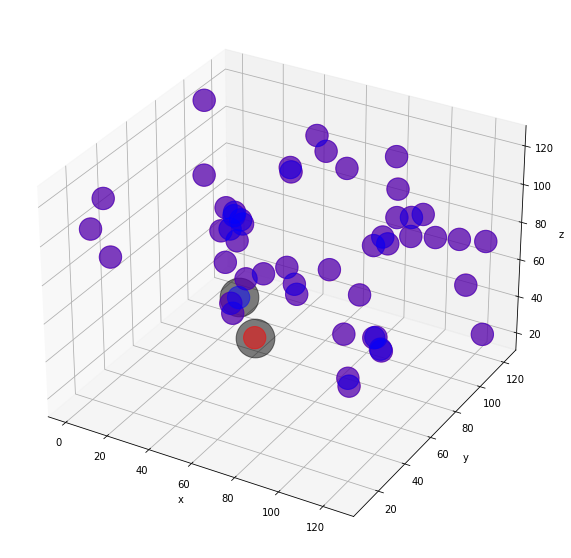

In [16]:
%matplotlib inline
#box1 = get_halo_lists("Chinchilla_L125_e14.txt")
#box2 = get_halo_lists("Chinchilla_L125_e5.txt")

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(box1[:, 3], box1[:, 4], box1[:, 5], zdir='z', s=500, c='r', alpha=0.5)
ax.scatter(box2[:, 3], box2[:, 4], box2[:, 5], zdir='z', s=500, c='b', alpha=0.5)

mvir, rvir, x, y, z = get_values(480874, new_file='Chinchilla_L125_e1.txt')
ax.scatter(x[0], y[0], z[0], zdir='z', s=1500, c='k', alpha=0.5)

mvir, rvir, x, y, z = get_values(278209, new_file='Chinchilla_L125_e2.txt')
ax.scatter(x[0], y[0], z[0], zdir='z', s=1500, c='k', alpha=0.5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

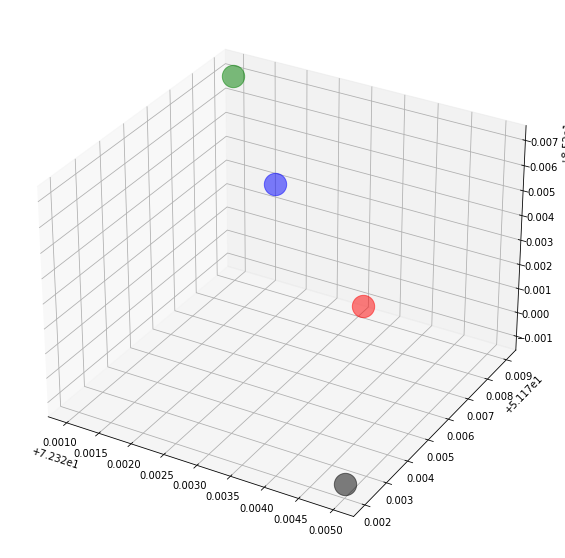

In [15]:
# plotting individual halo pairs
# i corresponds to the halo's index (ranked by mass)
%matplotlib inline
i = 1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
halo_names = names[i]

mvir, rvir, x, y, z = get_values(int(halo_names[0]), new_file='Chinchilla_L125_e1.txt')
ax.scatter(x[0], y[0], z[0], zdir='z', s=500, c='r', alpha=0.5)
                                 
mvir, rvir, x, y, z = get_values(int(halo_names[1]), new_file='Chinchilla_L125_e2.txt')
ax.scatter(x[0], y[0], z[0], zdir='z', s=500, c='g', alpha=0.5)
                                 
mvir, rvir, x, y, z = get_values(int(halo_names[2]), new_file='Chinchilla_L125_e5.txt')
ax.scatter(x[0], y[0], z[0], zdir='z', s=500, c='b', alpha=0.5)

mvir, rvir, x, y, z = get_values(int(halo_names[3]), new_file='Chinchilla_L125_e14.txt')
ax.scatter(x[0], y[0], z[0], zdir='z', s=500, c='k', alpha=0.5)

In [153]:
def crossmatch_old(halos):
    """
    Matches halos between simulations by mass.
    
    Parameters: 
        halos: 2D array of halos from a simulation with Nx6 arrays each (0=name, 1=mass, 2=rvir, 3=x, 4=y, 5=z)
        
    Output: 2D array of names (halo & matched halo)
    """
    shapes = np.zeros(len(halos))
    for i in range(len(halos)):
        halos[i] = halos[i][np.argsort(halos[i][:, 1])][:, ::-1]
        shapes[i] = halos[i].shape[0]
    
    size = int(np.max(shapes))
    x_cm = np.zeros((size,len(halos)))
    y_cm = np.zeros((size,len(halos)))
    z_cm = np.zeros((size,len(halos)))
    m_cm = np.zeros((size,len(halos)))
    names = np.zeros((size, len(halos)))
    
    for i in range(size):
        for j in range(len(halos)):
            names[i][j] = halos[j][i,0]
            m_cm[i][j] = halos[j][i,1]
            x_cm[i][j] = halos[j][i,3]
            y_cm[i][j] = halos[j][i,4]
            z_cm[i][j] = halos[j][i,5]

    return names, m_cm, x_cm, y_cm, z_cm

In [8]:
def crossmatch(halos):
    """
    Matches halos between simulations by mass.
    
    Parameters: 
        halos: 2D array of halos from a simulation with Nx6 arrays each (0=name, 1=mass, 2=rvir, 3=x, 4=y, 5=z)
        
    Output: 2D array of names (halo & matched halo)
    """
    size = halos[0].shape[0]
    halos[0] = halos[0][halos[0][:,1].argsort()]
    x_cm = np.zeros((size,len(halos)))
    y_cm = np.zeros((size,len(halos)))
    z_cm = np.zeros((size,len(halos)))
    m_cm = np.zeros((size,len(halos)))
    names = np.zeros((size, len(halos)))
    
    x_cm[:, 0] = halos[0][:,3]
    y_cm[:, 0] = halos[0][:,4]
    z_cm[:, 0] = halos[0][:,5]
    m_cm[:, 0] = halos[0][:,1]
    names[:, 0] = halos[0][:,0]
    
    current_halo = halos[0] #the base simulation
    for j in range(halos[0].shape[0]):
        distances = np.zeros((size, len(halos)-1))
        for i in range(len(halos)-1):
            halo_counter = i+1
            
            distances_x = [(current_halo[j,3]-halos[halo_counter][:,3])**2, (125-(current_halo[j,3]-halos[halo_counter][:,3]))**2, (125-(halos[halo_counter][:,3]-current_halo[j,3]))**2]
            xdist = np.array([min(idx) for idx in zip(*distances_x)]) 
            distances_y = [(current_halo[j,4]-halos[halo_counter][:,4])**2, (125-(current_halo[j,4]-halos[halo_counter][:,4]))**2, (125-(halos[halo_counter][:,4]-current_halo[j,4]))**2]
            ydist = np.array([min(idx) for idx in zip(*distances_y)])
            distances_z = [(current_halo[j,5]-halos[halo_counter][:,5])**2, (125-(current_halo[j,5]-halos[halo_counter][:,5]))**2, (125-(halos[halo_counter][:,5]-current_halo[j,5]))**2]
            zdist = np.array([min(idx) for idx in zip(*distances_z)])
            
            # report bad matches
            distances[:, i] = np.sqrt(xdist+ydist+zdist)
            if np.min(distances[:,i]) > current_halo[j,2]:
                print('No good matches for halo '+str(current_halo[j,0])+' in simulation '+str(halo_counter))
            
            #print(halos[halo_counter][:,3])
            #print(distances)
            
        indices = np.argmin(distances, axis=0)
        #print(indices)
        
        
        for i in range(len(halos)-1):
            halo_counter = i+1
            names[j, halo_counter] = halos[halo_counter][indices[i],0]
            m_cm[j, halo_counter] = halos[halo_counter][indices[i],1]
            x_cm[j, halo_counter] = halos[halo_counter][indices[i],3]
            y_cm[j, halo_counter] = halos[halo_counter][indices[i],4]
            z_cm[j, halo_counter] = halos[halo_counter][indices[i],5]
        
    return names, m_cm, x_cm, y_cm, z_cm

In [9]:
def get_halo_lists(filename):
    """
    Method to get formatted halo lists from a file.
    
    Parameters:
        filename: halo catalog file as a string
    
    Output: M-dimensional (M = # halos) list of Nx6 arrays (name, m, r, x, y, z)
    """
    halos = np.loadtxt(filename,usecols=(0,1,2,6,7,8))
    indices = np.unique(halos[:, 0],return_index=True)
    return halos[indices[1]]

In [12]:
%matplotlib qt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[0][0],points[1][0],points[2][0],c='k',s=1500, alpha=0.5)
ax.scatter(points[0][1:],points[1][1:],points[2][1:], c='r', s=500, alpha=0.5)

In [11]:
points = [[79.771, 16.888, 73.365], [80.077, 16.807, 73.01 ], [79.806, 17.724, 73.397]]

In [10]:
names, m_cm, x_cm, y_cm, z_cm = crossmatch([get_halo_lists("Chinchilla_L125_e1.txt"), get_halo_lists("Chinchilla_L125_e2.txt"), get_halo_lists("Chinchilla_L125_e5.txt"), get_halo_lists("Chinchilla_L125_e14.txt")])

No good matches for halo 250374.0 in simulation 1
No good matches for halo 250374.0 in simulation 2


In [160]:
m_cm

array([[9.21e+13, 9.17e+13, 9.19e+13, 9.22e+13],
       [9.29e+13, 9.30e+13, 9.28e+13, 9.30e+13],
       [9.45e+13, 9.20e+13, 9.21e+13, 9.39e+13],
       [9.72e+13, 9.72e+13, 9.73e+13, 9.73e+13],
       [9.78e+13, 9.83e+13, 9.80e+13, 9.81e+13],
       [1.01e+14, 1.01e+14, 1.01e+14, 1.01e+14],
       [1.02e+14, 1.02e+14, 1.02e+14, 1.02e+14],
       [1.03e+14, 1.01e+14, 1.00e+14, 1.00e+14],
       [1.05e+14, 1.05e+14, 1.05e+14, 1.04e+14],
       [1.06e+14, 1.06e+14, 1.06e+14, 1.06e+14],
       [1.06e+14, 1.06e+14, 1.06e+14, 1.06e+14],
       [1.07e+14, 1.07e+14, 1.07e+14, 1.06e+14],
       [1.07e+14, 1.07e+14, 1.07e+14, 1.07e+14],
       [1.09e+14, 1.09e+14, 1.09e+14, 1.08e+14],
       [1.10e+14, 1.10e+14, 1.10e+14, 1.10e+14],
       [1.16e+14, 1.16e+14, 1.16e+14, 1.16e+14],
       [1.18e+14, 1.18e+14, 1.19e+14, 1.18e+14],
       [1.22e+14, 1.22e+14, 1.18e+14, 1.20e+14],
       [1.29e+14, 1.29e+14, 1.29e+14, 1.29e+14],
       [1.32e+14, 1.32e+14, 1.32e+14, 1.32e+14],
       [1.32e+14, 1.

In [27]:
# calculate distances as a test

# arrays set up for every permutation of simulation combinations
distances = np.zeros((x_cm.shape[0], int(factorial(x_cm.shape[1])/factorial(x_cm.shape[1]-2)/2)))
full_distances = np.zeros((x_cm.shape[0], int(factorial(x_cm.shape[1])/factorial(x_cm.shape[1]-2)/2)))
masses = np.zeros((x_cm.shape[0], int(factorial(x_cm.shape[1])/factorial(x_cm.shape[1]-2)/2)))

counter = 0
for i in range(x_cm.shape[1]): # for every simulation box
    for j in range(i):
        if i!=j:
            # distances accounting for periodic boundary conditions (both directions)
            distances_x = [(x_cm[:,i]-x_cm[:,j])**2, (125-(x_cm[:,i]-x_cm[:,j]))**2, (125-(x_cm[:,j]-x_cm[:,i]))**2]
            xdist = np.array([min(idx) for idx in zip(*distances_x)]) 
            
            distances_y = [(y_cm[:,i]-y_cm[:,j])**2, (125-(y_cm[:,i]-y_cm[:,j]))**2, (125-(y_cm[:,j]-y_cm[:,i]))**2]
            ydist = np.array([min(idx) for idx in zip(*distances_y)])
            
            distances_z = [(z_cm[:,i]-z_cm[:,j])**2, (125-(z_cm[:,i]-z_cm[:,j]))**2, (125-(z_cm[:,j]-z_cm[:,i]))**2]
            zdist = np.array([min(idx) for idx in zip(*distances_z)])
            
            distances[:,counter] = np.sqrt(xdist+ydist+zdist)
            
            masses[:, counter] = (m_cm[:, i]+m_cm[:, j])/2
                
            counter+=1
            
        print(i,j)
#  [1.90159199e+01, 1.90120781e+01, 6.16441400e-03, 1.04880885e-02, 1.90239187e+01, 1.90200756e+01]

1 0
2 0
2 1
3 0
3 1
3 2


In [32]:
np.sqrt(zdist.max())

33.42700000000001

Text(0.5, 0, 'Distance Between Matched Halos (Mpc/h)')

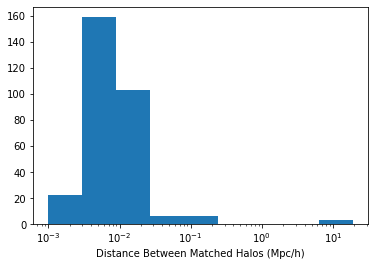

In [19]:
%matplotlib inline
plt.hist(distances.flatten(), bins=10**np.linspace(np.log10(np.min(distances)), np.log10(np.max(distances)), 10))
plt.xscale('log')
plt.xlabel('Distance Between Matched Halos (Mpc/h)')

In [551]:
distances.flatten()[distances.flatten()>1]

array([19.01591991, 19.01207806, 19.02391873, 19.02007555])

Text(0.5, 0, '$M_{vir} (M_\\odot/h)$')

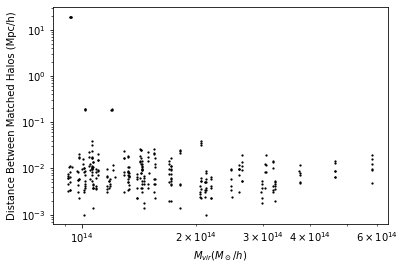

In [20]:
plt.scatter(masses, distances, s=1.5, c='k')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Distance Between Matched Halos (Mpc/h)')
plt.xlabel(r'$M_{vir} (M_\odot/h)$')

In [566]:
print(round((distances.flatten()[distances.flatten()>10].shape[0]/distances.flatten().shape[0]*100),2),'% of paired halos are separated by > 1Mpc.')

1.33 % of paired halos are separated by > 1Mpc.


[275636. 278210. 276746. 251485.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


1
[275636. 278210. 276746. 251485.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


2
[275636. 278210. 276746. 251485.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


5
[275636. 278210. 276746. 251485.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


14
[335847. 339033. 337315. 307013.]
1
[335847. 339033. 337315. 307013.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


2
[335847. 339033. 337315. 307013.]
5
[335847. 339033. 337315. 307013.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


14
[250374. 278209. 276745. 228838.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


1
[250374. 278209. 276745. 228838.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


2
[250374. 278209. 276745. 228838.]
5
[250374. 278209. 276745. 228838.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


14
[206930. 208917. 207772. 188671.]
1
[206930. 208917. 207772. 188671.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


2
[206930. 208917. 207772. 188671.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


5
[206930. 208917. 207772. 188671.]
14
[612247. 618470. 615170. 559442.]
1
[612247. 618470. 615170. 559442.]
2
[612247. 618470. 615170. 559442.]
5
[612247. 618470. 615170. 559442.]
14
[206929. 208916. 207771. 188670.]
1
[206929. 208916. 207771. 188670.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


2
[206929. 208916. 207771. 188670.]
5
[206929. 208916. 207771. 188670.]
14
[275633. 278207. 276743. 251482.]
1
[275633. 278207. 276743. 251482.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


2
[275633. 278207. 276743. 251482.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


5
[275633. 278207. 276743. 251482.]
14
[455013. 459481. 457085. 416126.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


1
[455013. 459481. 457085. 416126.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


2
[455013. 459481. 457085. 416126.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


5
[455013. 459481. 457085. 416126.]
14
[91207. 92174. 91851. 84086.]
1
[91207. 92174. 91851. 84086.]
2
[91207. 92174. 91851. 84086.]
5
[91207. 92174. 91851. 84086.]
14
[528162. 533501. 530450. 482463.]
1
[528162. 533501. 530450. 482463.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


2
[528162. 533501. 530450. 482463.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


5
[528162. 533501. 530450. 482463.]
14
[384729. 388442. 386476. 351746.]
1
[384729. 388442. 386476. 351746.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


2
[384729. 388442. 386476. 351746.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


5
[384729. 388442. 386476. 351746.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


14
[145287. 146648. 146057. 133439.]
1
[145287. 146648. 146057. 133439.]
2
[145287. 146648. 146057. 133439.]
5
[145287. 146648. 146057. 133439.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


14
[644542. 651126. 647627. 588594.]
1
[644542. 651126. 647627. 588594.]
2
[644542. 651126. 647627. 588594.]
5
[644542. 651126. 647627. 588594.]
14
[118057. 119206. 118760. 108546.]
1
[118057. 119206. 118760. 108546.]
2
[118057. 119206. 118760. 108546.]
5
[118057. 119206. 118760. 108546.]
14
[406864. 410813. 408763. 372150.]
1
[406864. 410813. 408763. 372150.]
2
[406864. 410813. 408763. 372150.]
5
[406864. 410813. 408763. 372150.]
14
[46116. 46577. 46436. 42560.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


1
[46116. 46577. 46436. 42560.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


2
[46116. 46577. 46436. 42560.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


5
[46116. 46577. 46436. 42560.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


14
[73365. 74100. 73783. 67465.]
1
[73365. 74100. 73783. 67465.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


2
[73365. 74100. 73783. 67465.]
5
[73365. 74100. 73783. 67465.]
14
[167511. 169137. 168500. 153971.]
1
[167511. 169137. 168500. 153971.]
2
[167511. 169137. 168500. 153971.]
5
[167511. 169137. 168500. 153971.]
14
[612246. 618469. 615169. 559441.]
1
[612246. 618469. 615169. 559441.]
2
[612246. 618469. 615169. 559441.]
5
[612246. 618469. 615169. 559441.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


14
[644541. 651125. 647626. 588593.]
1
[644541. 651125. 647626. 588593.]
2
[644541. 651125. 647626. 588593.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


5
[644541. 651125. 647626. 588593.]
14
[46115. 46576. 46435. 42559.]
1
[46115. 46576. 46435. 42559.]
2
[46115. 46576. 46435. 42559.]
5
[46115. 46576. 46435. 42559.]
14
[46114. 46575. 46434. 42558.]
1
[46114. 46575. 46434. 42558.]
2
[46114. 46575. 46434. 42558.]
5
[46114. 46575. 46434. 42558.]
14
[528161. 533500. 530449. 482462.]
1
[528161. 533500. 530449. 482462.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


2
[528161. 533500. 530449. 482462.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


5
[528161. 533500. 530449. 482462.]
14
[580979. 586843. 583704. 530768.]
1
[580979. 586843. 583704. 530768.]
2
[580979. 586843. 583704. 530768.]
5
[580979. 586843. 583704. 530768.]
14
[580978. 586842. 583703. 530767.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


1
[580978. 586842. 583703. 530767.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


2
[580978. 586842. 583703. 530767.]
5
[580978. 586842. 583703. 530767.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


14
[612245. 618468. 615168. 559440.]
1
[612245. 618468. 615168. 559440.]
2
[612245. 618468. 615168. 559440.]
5
[612245. 618468. 615168. 559440.]
14
[504143. 509217. 506278. 460553.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


1
[504143. 509217. 506278. 460553.]
2
[504143. 509217. 506278. 460553.]
5
[504143. 509217. 506278. 460553.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


14
[644540. 651124. 647625. 588592.]
1
[644540. 651124. 647625. 588592.]
2
[644540. 651124. 647625. 588592.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


5
[644540. 651124. 647625. 588592.]
14
[612244. 618467. 615167. 559439.]
1
[612244. 618467. 615167. 559439.]
2
[612244. 618467. 615167. 559439.]
5
[612244. 618467. 615167. 559439.]
14
[406863. 410812. 408762. 372149.]
1
[406863. 410812. 408762. 372149.]
2
[406863. 410812. 408762. 372149.]
5
[406863. 410812. 408762. 372149.]
14
[455012. 459480. 457084. 416125.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


1
[455012. 459480. 457084. 416125.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


2
[455012. 459480. 457084. 416125.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


5
[455012. 459480. 457084. 416125.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


14
[406862. 410811. 408761. 372148.]
1
[406862. 410811. 408761. 372148.]
2
[406862. 410811. 408761. 372148.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


5
[406862. 410811. 408761. 372148.]
14
[644539. 651123. 647624. 588591.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


1
[644539. 651123. 647624. 588591.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


2
[644539. 651123. 647624. 588591.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


5
[644539. 651123. 647624. 588591.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


14
[553786. 559374. 556270. 506000.]
1
[553786. 559374. 556270. 506000.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


2
[553786. 559374. 556270. 506000.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


5
[553786. 559374. 556270. 506000.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


14
[145286. 146647. 146056. 133438.]
1
[145286. 146647. 146056. 133438.]
2
[145286. 146647. 146056. 133438.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


5
[145286. 146647. 146056. 133438.]
14
[206928. 208915. 207770. 188669.]
1
[206928. 208915. 207770. 188669.]
2
[206928. 208915. 207770. 188669.]
5
[206928. 208915. 207770. 188669.]
14
[455011. 459479. 457083. 416124.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


1
[455011. 459479. 457083. 416124.]
2
[455011. 459479. 457083. 416124.]
5
[455011. 459479. 457083. 416124.]
14
[363244. 366720. 364876. 331898.]
1
[363244. 366720. 364876. 331898.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


2
[363244. 366720. 364876. 331898.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


5
[363244. 366720. 364876. 331898.]
14
[406861. 410810. 408760. 372147.]
1
[406861. 410810. 408760. 372147.]
2
[406861. 410810. 408760. 372147.]
5
[406861. 410810. 408760. 372147.]
14

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt



[553785. 559373. 556269. 505999.]
1
[553785. 559373. 556269. 505999.]
2
[553785. 559373. 556269. 505999.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


5
[553785. 559373. 556269. 505999.]
14
[167510. 169136. 168499. 153970.]
1
[167510. 169136. 168499. 153970.]
2
[167510. 169136. 168499. 153970.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


5
[167510. 169136. 168499. 153970.]
14
[480875. 485648. 482998. 439563.]
1
[480875. 485648. 482998. 439563.]
2
[480875. 485648. 482998. 439563.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


5
[480875. 485648. 482998. 439563.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


14
[612243. 618466. 615166. 559438.]
1
[612243. 618466. 615166. 559438.]
2
[612243. 618466. 615166. 559438.]
5
[612243. 618466. 615166. 559438.]
14
[504142. 509216. 506277. 460552.]
1
[504142. 509216. 506277. 460552.]
2
[504142. 509216. 506277. 460552.]
5
[504142. 509216. 506277. 460552.]
14
[167509. 169135. 168498. 153969.]
1
[167509. 169135. 168498. 153969.]
2
[167509. 169135. 168498. 153969.]
5
[167509. 169135. 168498. 153969.]
14
[167508. 169134. 168497. 153968.]
1
[167508. 169134. 168497. 153968.]
2
[167508. 169134. 168497. 153968.]
5
[167508. 169134. 168497. 153968.]
14
[250373. 252763. 251496. 228837.]
1
[250373. 252763. 251496. 228837.]
2
[250373. 252763. 251496. 228837.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


5
[250373. 252763. 251496. 228837.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


14
[167507. 169133. 168496. 153967.]
1
[167507. 169133. 168496. 153967.]
2
[167507. 169133. 168496. 153967.]
5
[167507. 169133. 168496. 153967.]
14
[480874. 485647. 482997. 439562.]
1
[480874. 485647. 482997. 439562.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


2
[480874. 485647. 482997. 439562.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


5
[480874. 485647. 482997. 439562.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


14
[167506. 169132. 168495. 153966.]
1
[167506. 169132. 168495. 153966.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


2
[167506. 169132. 168495. 153966.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


5
[167506. 169132. 168495. 153966.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


14


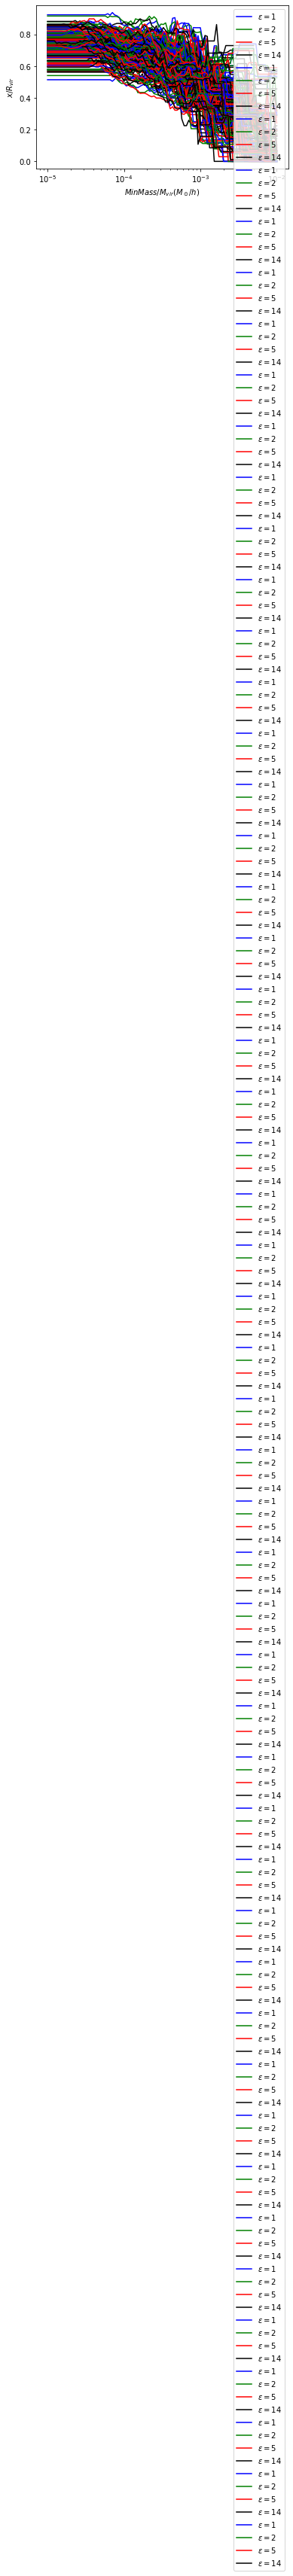

In [15]:
%matplotlib inline
# calculate axis ratios as a function of minmass for an individual halo
n_files = 4
epsilon_vals = [1,2,5,14]
colors = ['b','g','r','k']
lines = []
n = np.logspace(-5,-2,num=100)
all_lines = []
# setup, file = index of the halo (ranked by mass)
for k in range(50):
    file = k

    for i in range(n_files): # for every file
        axis_vals = np.zeros(len(n))
        halo = int(names[file, i])
        print(names[k])
        name, mass, r, x_pos, y_pos, z_pos = np.loadtxt('Chinchilla_L125_e'+str(epsilon_vals[i])+'.txt',usecols=(0,1,2,6,7,8)).T
        m, radius, x, y, z = get_values(halo)

        for j in range(len(n)): # for every minmass
            m, radius, x, y, z = get_values(halo, minmass=n[j]*m[0])
            axis_vals[j] =  get_ca(np.array([x,y,z]).T)

        
        lines.append(plt.plot(n, axis_vals, c=colors[i], label=r'$\varepsilon=$'+str(epsilon_vals[i])))

        print(epsilon_vals[i])
        all_lines.append(axis_vals)

    plt.xscale('log')
    plt.ylabel(r'$x/R_{vir}$')
    plt.xlabel(r'$MinMass/M_{vir} (M_\odot/h)$')
    plt.legend()

[250374. 278209. 276745. 228838.]
-
[[79.771 16.888 73.365]
 [80.077 16.807 73.01 ]
 [79.806 17.724 73.397]]
-
[[79.771 16.888 73.365]
 [80.077 16.807 73.01 ]
 [79.806 17.724 73.397]]
-
[[79.771 16.888 73.365]
 [80.077 16.807 73.01 ]]
-
[[79.771 16.888 73.365]
 [80.077 16.807 73.01 ]]
-
[[79.771 16.888 73.365]
 [80.077 16.807 73.01 ]]
-
[[79.771 16.888 73.365]
 [80.077 16.807 73.01 ]]
-
[[79.771 16.888 73.365]
 [80.077 16.807 73.01 ]]
1
[250374. 278209. 276745. 228838.]
-
[[66.602 25.92  83.69 ]
 [66.399 25.627 83.455]]
-
[[66.602 25.92  83.69 ]
 [66.399 25.627 83.455]]
-
[[66.602 25.92  83.69 ]
 [66.399 25.627 83.455]]
-
[[66.602 25.92  83.69 ]
 [66.399 25.627 83.455]]
-
[[66.602 25.92  83.69 ]
 [66.399 25.627 83.455]]
-
[[66.602 25.92  83.69 ]
 [66.399 25.627 83.455]]
2
[250374. 278209. 276745. 228838.]
5
[250374. 278209. 276745. 228838.]
-
[[79.78  16.89  73.36 ]
 [80.08  16.816 73.021]
 [79.835 17.757 73.396]]
-
[[79.78  16.89  73.36 ]
 [80.08  16.816 73.021]
 [79.835 17.757 73.396

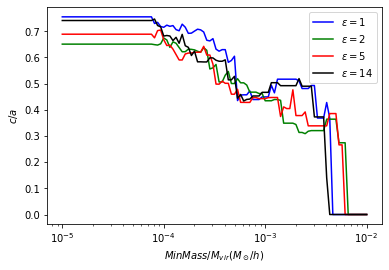

In [34]:
%matplotlib inline
# calculate axis ratios as a function of minmass for an individual halo
n_files = 4
epsilon_vals = [1,2,5,14]
colors = ['b','g','r','k']
lines = []
n = np.logspace(-5,-2,num=100)
all_lines = []
# setup, file = index of the halo (ranked by mass)

file = 2

for i in range(n_files): # for every file
    axis_vals = np.zeros(len(n))
    halo = int(names[file, i])
    print(names[file])
    name, mass, r, x_pos, y_pos, z_pos = np.loadtxt('Chinchilla_L125_e'+str(epsilon_vals[i])+'.txt',usecols=(0,1,2,6,7,8)).T
    m, radius, x, y, z = get_values(halo)

    for j in range(len(n)): # for every minmass
        m, radius, x, y, z = get_values(halo, minmass=n[j]*m[0])
        if m.shape[0] > 1:
            try:
                axis_vals[j] =  get_ca(np.array([x,y,z]).T)
            except:
                axis_vals[j] = 0
                print('-')
                print(np.array([x,y,z]).T)

    
    lines.append(plt.plot(n, axis_vals, c=colors[i], label=r'$\varepsilon=$'+str(epsilon_vals[i])))

    print(epsilon_vals[i])
    all_lines.append(axis_vals)

plt.xscale('log')
plt.ylabel(r'$c/a$')
plt.xlabel(r'$MinMass/M_{vir} (M_\odot/h)$')
plt.legend()

In [23]:
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

In [145]:
mvir, rvir, x, y, z = get_values(46114)
get_axes(np.array([x,y,z]).T)

array([1.03849995, 0.88630668, 0.77370179])

In [63]:
np.array(all_lines).shape

(121, 100)

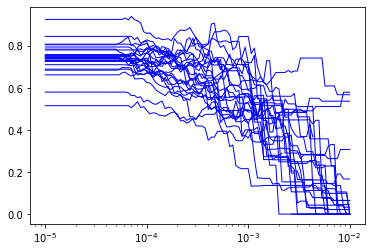

In [16]:
linevals = np.array(all_lines)
for i in range(linevals.shape[1]):
    if i%4 == 0:
        plt.plot(n,linevals[i],c='b', lw=1)
        plt.xscale('log')

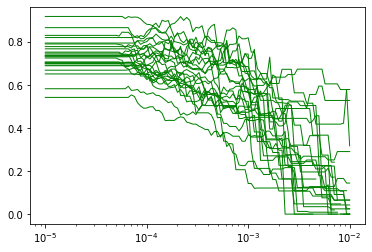

In [17]:
for i in range(linevals.shape[1]):
    if i%4 == 1:
        plt.plot(n,linevals[i],c='g', lw=1)
        plt.xscale('log')

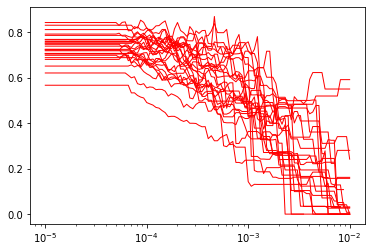

In [18]:
for i in range(linevals.shape[1]):
    if i%4 == 2:
        plt.plot(n,linevals[i],c='r', lw=1)
        plt.xscale('log')

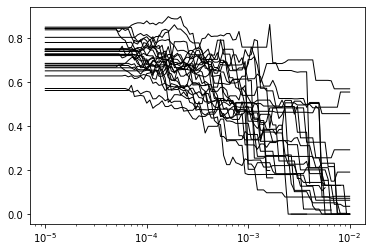

In [19]:
for i in range(linevals.shape[1]):
    if i%4 == 3:
        plt.plot(n,linevals[i],c='k', lw=1)
        plt.xscale('log')

[46114. 46575. 46434. 42558.]


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


1


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


2


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


5


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


14


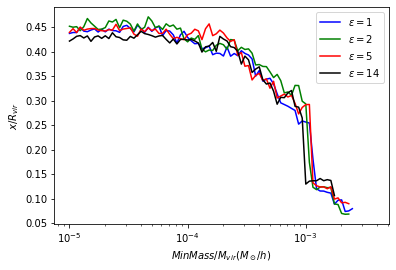

In [123]:
%matplotlib inline
# calculate axis ratios as a function of minmass for an individual halo
n_files = 4
epsilon_vals = [1,2,5,14]
colors = ['b','g','r','k']
lines = []
n = np.logspace(-5,-2,num=100)
file = 0
print(names[file])
for i in range(n_files): # for every file
    axis_vals = np.zeros(len(n))
    halo = int(names[file, i])
    name, mass, r, x_pos, y_pos, z_pos = np.loadtxt('Chinchilla_L125_e'+str(epsilon_vals[i])+'.txt',usecols=(0,1,2,6,7,8)).T
    m, radius, x, y, z = get_values(halo)

    for j in range(len(n)): # for every minmass
        m, radius, x, y, z = get_values(halo, minmass=n[j]*m[0])
        halo_data_bootstrapped = get_statistics(np.array([x,y,z]).T, 1000, get_ca)
        quantiles = get_quantiles(halo_data_bootstrapped)
        axis_vals[j] = quantiles['median']

    if True:
        lines.append(plt.plot(n, axis_vals, c=colors[i], label=r'$\varepsilon=$'+str(epsilon_vals[i])))

    print(epsilon_vals[i])

plt.xscale('log')
plt.ylabel(r'$x/R_{vir}$')
plt.xlabel(r'$MinMass/M_{vir} (M_\odot/h)$')
plt.legend()

In [86]:
lines

[]

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


1


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


2


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


5


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


14


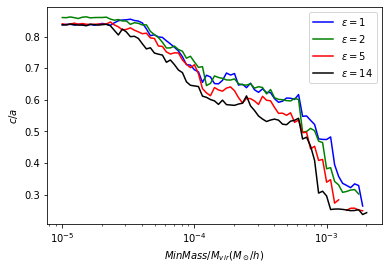

In [216]:
%matplotlib inline
# calculate axis ratios as a function of minmass for an individual halo

# setup, file = index of the halo (ranked by mass)
file = 45
n_files = 4
epsilon_vals = [1,2,5,14]
colors = ['b','g','r','k']
lines = []
n = np.logspace(-5,-2,num=100)

for i in range(n_files): # for every file
    axis_vals = np.zeros(len(n))
    halo = int(names[file, i])
    name, mass, r, x_pos, y_pos, z_pos = np.loadtxt('Chinchilla_L125_e'+str(epsilon_vals[i])+'.txt',usecols=(0,1,2,6,7,8)).T
    m, radius, x, y, z = get_values(halo)
    
    for j in range(len(n)): # for every minmass
        m, radius, x, y, z = get_values(halo, minmass=n[j]*m[0])
        halo_data_bootstrapped = get_statistics(np.array([x,y,z]).T, 1000, get_ca)
        quantiles = get_quantiles(halo_data_bootstrapped)
        axis_vals[j] = quantiles['median']
    
    lines.append(plt.plot(n, axis_vals, c=colors[i], label=r'$\varepsilon=$'+str(epsilon_vals[i])))
    print(epsilon_vals[i])

plt.xscale('log')
plt.ylabel(r'$c/a$')
plt.xlabel(r'$MinMass/M_{vir} (M_\odot/h)$')
plt.legend()

In [56]:
names[45]

array([612247., 618470., 615170., 559442.])

Text(0.5, 0, '$MinMass/M_{vir} (M_\\odot)$')

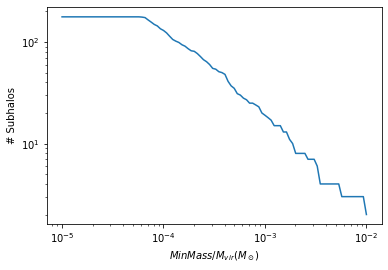

In [30]:
file = 2
sizes = np.zeros(len(n))
halo = int(names[file, 0])
name, mass, r, x_pos, y_pos, z_pos = np.loadtxt('Chinchilla_L125_e1.txt',usecols=(0,1,2,6,7,8)).T
m, radius, x, y, z = get_values(halo)

for j in range(len(n)):
    m, radius, x, y, z = get_values(halo, minmass=n[j]*m[0])
    sizes[j] = m.shape[0]-1

plt.plot(n, sizes)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('# Subhalos')
plt.xlabel(r'$MinMass/M_{vir} (M_\odot)$')

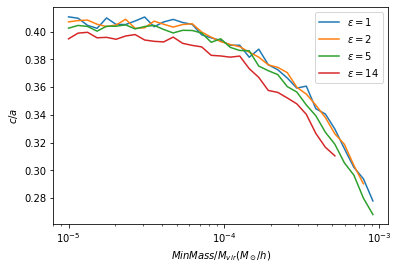

In [564]:
# not related - a rough re-simulation of the main axis plot to check that everything was working

%matplotlib inline
n = np.logspace(-5,-2,num=50)
e1 = plt.plot(n, ca_e1_mean, label=r'$\varepsilon=1$', c='b')
e2 = plt.plot(n, ca_e2_mean, label=r'$\varepsilon=2$', c='g')
e5 = plt.plot(n, ca_e5_mean, label=r'$\varepsilon=5$', c='r')
e14 = plt.plot(n, ca_e14_mean, label=r'$\varepsilon=14$', c='k')

plt.xscale('log')
plt.ylabel(r'$c/a$')
plt.xlabel(r'$MinMass/M_{vir} (M_\odot/h)$')
plt.legend()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
 
def random_sphere(N):
    """ random_sphere returns the azimuthal angle, phi, and polar angle, theta
    of N points generated uniformly at random over the surface of a sphere.
    """
    # See https://mathworld.wolfram.com/SpherePointPicking.html for the
    # algorithm. (Basically just the Inverse Transfer Method.)
    phi = 2*np.pi*random.random(N)
    theta = np.arccos(2*random.random(N) - 1)
    return phi, theta
 
def spherical_to_cartesian(phi, theta, r):
    """ spherical_to_cartesian converts spherical coordiantes to cartesian
    coordinates. Here, phi is the azimuthal angle, theta is the polar angle, and
    r is the radius.
    """
    # See https://mathworld.wolfram.com/SphericalCoordinates.html, but note the
    # difference in convention.
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(theta)
    return x, y, z
 
def random_ball(N, R):
    """ random_ball returns a N points (x, y, z) generated uniformly at
    random from within a ball of radius r.
    """
    phi, theta = random_sphere(N)
    # Inverse Transform Method, See
    # http://www.columbia.edu/~ks20/4404-Sigman/4404-Notes-ITM.pdf
    r = random.random(N)**(1.0/3) * R
    return spherical_to_cartesian(phi, theta, r)
    
def random_ellipsoid(N, a, b, c):
    """ random_ellipsoid returns N points generated uniformly at random inside
    an ellipsoid. The axes of the ellipsoid are given by (a, b, c) which
    are aligned with the x, y, and z axes, respectively.
    """
    x, y, z = random_ball(N, 1.0)
    x[0] = 0
    y[0] = 0
    z[0] = 0
    return x*a, y*b, z*c

In [236]:
all_vals = np.zeros(100)

for i in range(100):
    x, y, z = random_ellipsoid(500,1,1,1)
    
    a_bootstrap = np.zeros(20)
    a_random = get_a(np.array([x,y,z]).T)
    
    for j in range(20):
        halo_data_bootstrapped = get_statistics(np.array([x,y,z]).T, 100, get_a)
        quantiles = get_quantiles(halo_data_bootstrapped)
        a_bootstrap[j] = quantiles['median']
    
    all_vals[i] = np.mean(a_bootstrap)/a_random
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [235]:
get_axes(np.array([x,y,z]).T)

array([1.04768891, 0.98596271, 0.95192313])

In [31]:
all_vals = []

for i in range(10):
    x, y, z = random_ellipsoid(500,1,1,1)
    
    a_bootstrap = np.zeros(20)
    a_random = get_a(np.array([x,y,z]).T)
    
    for j in range(20):
        halo_data_bootstrapped = get_statistics(np.array([x,y,z]).T, 100, get_a)
        quantiles = get_quantiles(halo_data_bootstrapped)
        a_bootstrap[j] = quantiles['median']
    
    all_vals.append(a_bootstrap/a_random)
    print(i)

0
1
2
3
4
5
6
7
8
9


Text(0.5, 0, '$a_{bootstrap} / a_{random}$')

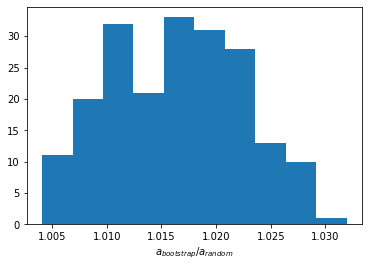

In [32]:
plt.hist(np.array(all_vals).flatten(), bins=10)
plt.xlabel(r'$a_{bootstrap} / a_{random}$')

Text(0.5, 0, '$a_{bootstrap} / a_{random}$')

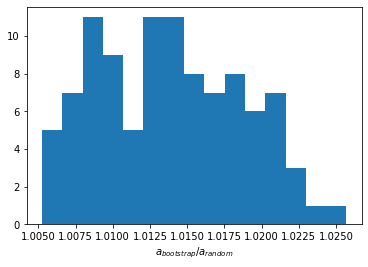

In [240]:
plt.hist(all_vals, bins=15)
plt.xlabel(r'$a_{bootstrap} / a_{random}$')

0
50
100
150
200
250
300
350
400
450


Text(0.5, 0, '$a_{bootstrap}/a_{random}$')

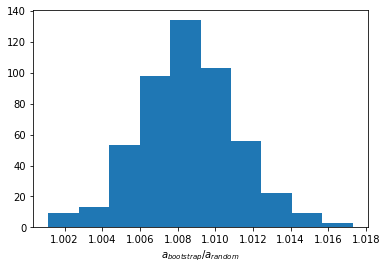

In [34]:
m, radius, x, y, z = get_values(names[48,0])

a_bootstrap = np.zeros(500)
a_random = get_a(np.array([x,y,z]).T)

for j in range(500):
    halo_data_bootstrapped = get_statistics(np.array([x,y,z]).T, 100, get_a)
    quantiles = get_quantiles(halo_data_bootstrapped)
    a_bootstrap[j] = quantiles['median']
    
    if j%50 ==0:
        print(j)

plt.hist(a_bootstrap/a_random)
plt.xlabel(r'$a_{bootstrap}/a_{random}$')

In [88]:
%matplotlib inline
# calculate axis ratios as a function of minmass for an individual halo
n_files = 4
min_val = 10**-5
epsilon_vals = [1, 2,5,14]
n = np.logspace(-5,-2,num=100)
values = np.zeros((4, 50))
counts = np.zeros(50)
# setup, file = index of the halo (ranked by mass)
for i in range(n_files):
    name, mass, r, x_pos, y_pos, z_pos = np.loadtxt('Chinchilla_L125_e'+str(epsilon_vals[i])+'.txt',usecols=(0,1,2,6,7,8)).T
    print(epsilon_vals[i])
    
    for k in range(50):
        file = k
        halo = int(names[file, i])
        #print(halo)
        m, radius, x, y, z = get_values(halo)
        counts[k] = m.shape[0]
        m, radius, x, y, z = get_values(halo, minmass=min_val * m[0])
        values[i,k] =  get_ca(np.array([x,y,z]).T)
        

1
2
5
14


Text(0.5, 1.0, '$MinMass/M_{vir} = 10^{-3}$')

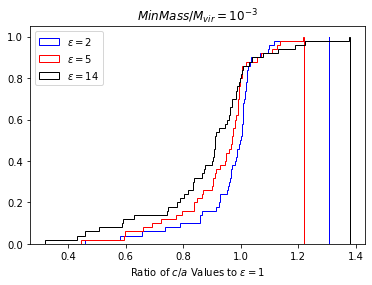

In [78]:
plt.hist(values[1,:]/values[0,:],histtype="step",color='b',cumulative=True, density=True, bins=500, label=r'$\varepsilon=2$')
plt.hist(values[2,:]/values[0,:],histtype="step",color='r',cumulative=True, density=True, bins=500,label=r'$\varepsilon=5$')
plt.hist(values[3,:]/values[0,:],histtype="step",color='k',cumulative=True, density=True, bins=500,label=r'$\varepsilon=14$')
plt.legend(loc='upper left')
plt.xlabel(r'Ratio of $c/a$ Values to $\varepsilon=1$')
plt.title(r'$MinMass/M_{vir} = 10^{-3}$')

Text(0.5, 1.0, '$MinMass/M_{vir} = 10^{-5}$')

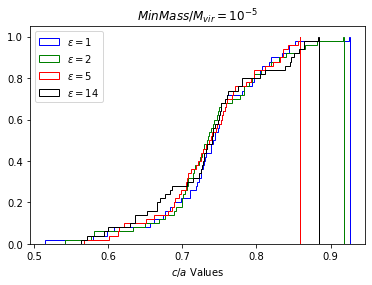

In [89]:
plt.hist(values[0,:],histtype="step",color='b',cumulative=True, density=True, bins=500, label=r'$\varepsilon=1$')
plt.hist(values[1,:],histtype="step",color='g',cumulative=True, density=True, bins=500, label=r'$\varepsilon=2$')
plt.hist(values[2,:],histtype="step",color='r',cumulative=True, density=True, bins=500,label=r'$\varepsilon=5$')
plt.hist(values[3,:],histtype="step",color='k',cumulative=True, density=True, bins=500,label=r'$\varepsilon=14$')
plt.legend(loc='upper left')
plt.xlabel(r'$c/a$ Values')
plt.title(r'$MinMass/M_{vir} = 10^{-5}$')

In [44]:
from scipy.stats import ks_2samp

In [95]:
ks_2samp(values[2,:], values[3,:])

KstestResult(statistic=0.12, pvalue=0.8692618870414056)

In [94]:
np.mean(values[3,:]/values[0,:])

0.8864387115470383

Text(0.5, 1.0, '$MinMass/M_{vir} = 10^{-3}$')

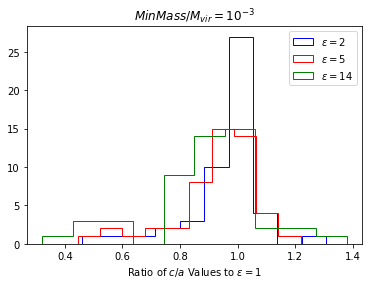

In [88]:
plt.hist(values[1,:]/values[0,:],histtype="step",color='b',label=r'$\varepsilon=2$')
plt.hist(values[2,:]/values[0,:],histtype="step",color='r',label=r'$\varepsilon=5$')
plt.hist(values[3,:]/values[0,:],histtype="step",color='g',label=r'$\varepsilon=14$')
plt.legend()
plt.xlabel(r'Ratio of $c/a$ Values to $\varepsilon=1$')
plt.title(r'$MinMass/M_{vir} = 10^{-3}$')

In [106]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

Text(0.5, 0.98, '$MinMass/M_{vir} = 10^{-4}$')

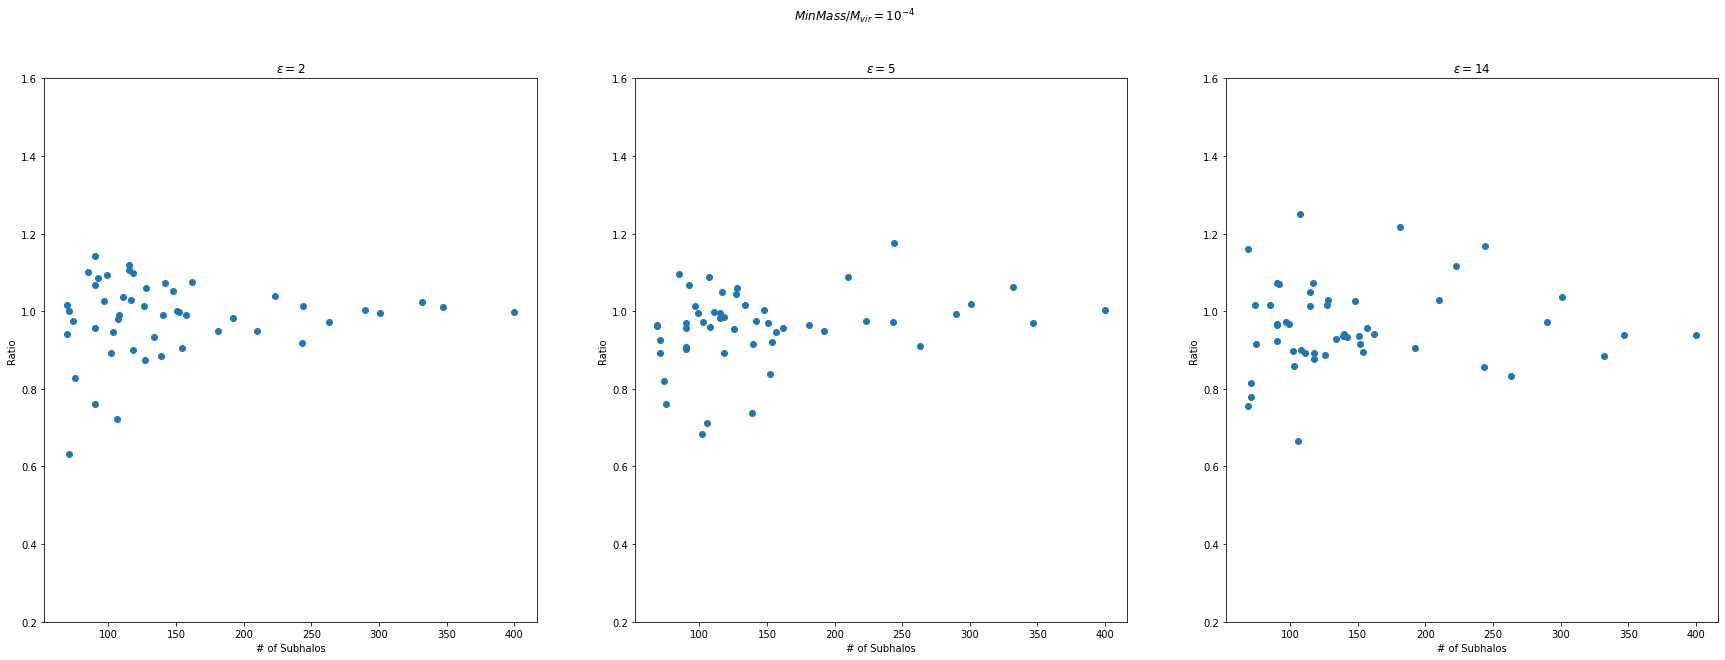

In [116]:
fig, ax = plt.subplots(1,3,figsize=(30,10))
ax[0].scatter(counts, values[1,:]/values[0,:])
ax[0].set_ylabel('Ratio')
ax[0].set_xlabel('# of Subhalos')
ax[0].set_title(r'$\varepsilon=2$')
ax[0].set_ylim(0.2,1.6)

ax[1].scatter(counts, values[2,:]/values[0,:])
ax[1].set_ylabel('Ratio')
ax[1].set_xlabel('# of Subhalos')
ax[1].set_title(r'$\varepsilon=5$')
ax[1].set_ylim(0.2,1.6)

ax[2].scatter(counts, values[3,:]/values[0,:])
ax[2].set_ylabel('Ratio')
ax[2].set_xlabel('# of Subhalos')
ax[2].set_title(r'$\varepsilon=14$')
ax[2].set_ylim(0.2,1.6)


plt.suptitle(r'$MinMass/M_{vir} = 10^{-4}$')

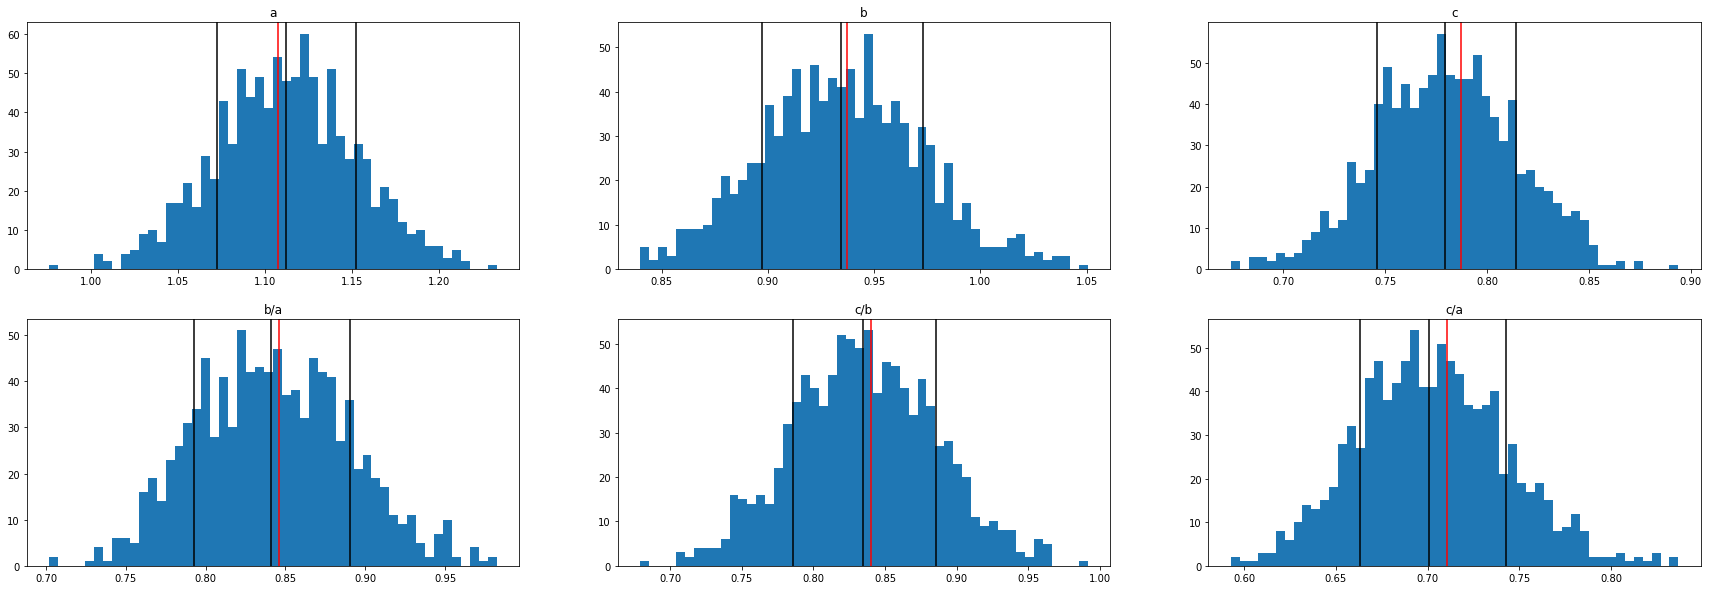

In [54]:
#testing sampling on  406861
mvir, rvir, x, y, z = get_values(406861)
halo_data = np.array([x,y,z]).T

halo_data_bootstrapped = get_statistics(halo_data,1000, get_axes)
a,b,c = halo_data_bootstrapped[:,0], halo_data_bootstrapped[:,1], halo_data_bootstrapped[:,2]
real_a, real_b, real_c = get_axes(halo_data)

# histograms of bootstrap sampled axes a/b/c on 480875
fig, ax = plt.subplots(2,3,figsize=(30,10))
ax[0,0].hist(a, bins=50)
ax[0,0].set_title('a')
quantiles = get_quantiles(a)
ax[0,0].axvline(x=quantiles['median'],c='k') 
ax[0,0].axvline(x=quantiles['1sigma'][0],c='k') 
ax[0,0].axvline(x=quantiles['1sigma'][1],c='k') 
ax[0,0].axvline(x=real_a,c='r') 

ax[0,1].hist(b, bins=50)
ax[0,1].set_title('b')
quantiles = get_quantiles(b)
ax[0,1].axvline(x=quantiles['median'],c='k') 
ax[0,1].axvline(x=quantiles['1sigma'][0],c='k') 
ax[0,1].axvline(x=quantiles['1sigma'][1],c='k') 
ax[0,1].axvline(x=real_b,c='r') 

ax[0,2].hist(c, bins=50)
ax[0,2].set_title('c')
quantiles = get_quantiles(c)
ax[0,2].axvline(x=quantiles['median'],c='k') 
ax[0,2].axvline(x=quantiles['1sigma'][0],c='k') 
ax[0,2].axvline(x=quantiles['1sigma'][1],c='k') 
ax[0,2].axvline(x=real_c,c='r') 

ax[1,0].hist(b/a, bins=50)
ax[1,0].set_title('b/a')
quantiles = get_quantiles(b/a)
ax[1,0].axvline(x=quantiles['median'],c='k') 
ax[1,0].axvline(x=quantiles['1sigma'][0],c='k') 
ax[1,0].axvline(x=quantiles['1sigma'][1],c='k') 
ax[1,0].axvline(x=real_b/real_a,c='r') 

ax[1,1].hist(c/b, bins=50)
ax[1,1].set_title('c/b')
quantiles = get_quantiles(c/b)
ax[1,1].axvline(x=quantiles['median'],c='k') 
ax[1,1].axvline(x=quantiles['1sigma'][0],c='k') 
ax[1,1].axvline(x=quantiles['1sigma'][1],c='k') 
ax[1,1].axvline(x=real_c/real_b,c='r') 

ax[1,2].hist(c/a, bins=50)
ax[1,2].set_title('c/a')
quantiles = get_quantiles(c/a)
ax[1,2].axvline(x=quantiles['median'],c='k') 
ax[1,2].axvline(x=quantiles['1sigma'][0],c='k') 
ax[1,2].axvline(x=quantiles['1sigma'][1],c='k') 
ax[1,2].axvline(x=real_c/real_a,c='r') 

In [59]:
m, radius, x, y, z = get_values(480875)
get_ca(np.array([x,y,z]).T)

0.7447720439004999